In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from garanapy import event

In [2]:
data_path = "../data"

In [9]:
data_manager = event.DataManager()
data_manager.open_events(data_path, n_files=100)

Output()

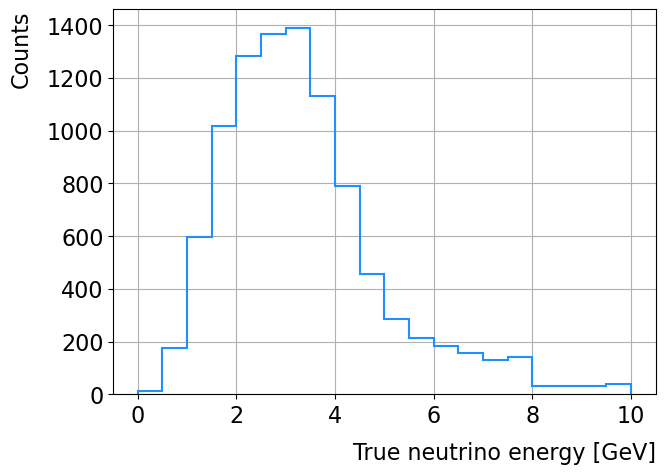

In [13]:
fig, ax = plt.subplots(figsize=(7,5))

plt.hist(data_manager.get_true_nu_energy(), bins=np.linspace(0.0, 10.0, 21), histtype="step", linewidth=1.5, color="dodgerblue")

ax.set_xlabel("True neutrino energy [GeV]", fontsize=16, labelpad=10, loc="right")
ax.set_ylabel("Counts", fontsize=16, labelpad=10, loc="top")

ax.tick_params(axis='both', which='major', labelsize=16)
ax.grid()

plt.show()

In [14]:
data_manager.search_primary_muon()

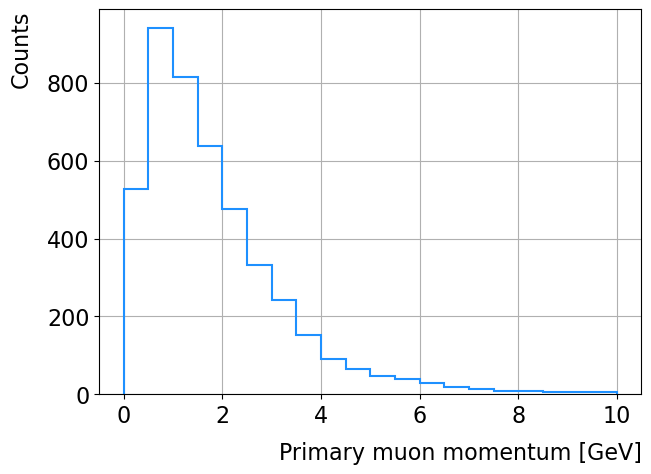

In [17]:
fig, ax = plt.subplots(figsize=(7,5))

plt.hist(data_manager.get_primary_muon_momentum(), bins=np.linspace(0.0, 10.0, 21), histtype="step", linewidth=1.5, color="dodgerblue")

ax.set_xlabel("Primary muon momentum [GeV]", fontsize=16, labelpad=10, loc="right")
ax.set_ylabel("Counts", fontsize=16, labelpad=10, loc="top")

ax.tick_params(axis='both', which='major', labelsize=16)
ax.grid()

plt.show()